In [1]:
import json
import os
import pandas as pd
import numpy as np
from functools import reduce
import re
from collections import Counter
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
import seaborn as sns
import copy
from statistics import mean
seed = 42
np.random.seed(seed)
import argparse

In [2]:
beta_file = "/mnt/dzl_bioinf/binliu/deepRNA/deepRNA/deepRNA_Py/post_hoc_all_samples/beta_finetune/post_hoc_scripts/selected_betas.txt"

beta_val = []
with open(beta_file, 'r') as f:
    for line in f:
        beta_val.append(int(line.strip()))

f.close()


In [3]:
prior_list = []
simple_list = []

In [4]:
root_dir = "/mnt/dzl_bioinf/binliu/deepRNA/beta_finetuning_results/"


In [5]:
prior_list.append(
    "/mnt/dzl_bioinf/binliu/deepRNA/data_and_results_all_samples_gene_no_earlystopping_500_epochs_sigma_mu_while_training/new_latent_results/priorVAE.npy")
prior_list.append(
    "/mnt/dzl_bioinf/binliu/deepRNA/data_and_results_all_samples_gene_no_earlystopping_500_epochs_sigma_mu_while_training/new_latent_results/beta_priorVAE.npy")
for i in beta_val:
    prior_list.append(root_dir + 'results_for_beta_' +
                      str(i) + '/new_latent_results/beta_priorVAE.npy')


In [6]:
simple_list.append(
    "/mnt/dzl_bioinf/binliu/deepRNA/data_and_results_all_samples_gene_no_earlystopping_500_epochs_sigma_mu_while_training/new_latent_results/simpleVAE.npy")
simple_list.append(
    "/mnt/dzl_bioinf/binliu/deepRNA/data_and_results_all_samples_gene_no_earlystopping_500_epochs_sigma_mu_while_training/new_latent_results/beta_simpleVAE.npy")
for i in beta_val:
    simple_list.append(root_dir + 'results_for_beta_' +
                      str(i) + '/new_latent_results/beta_simpleVAE.npy')


In [7]:
main_dir = '/mnt/dzl_bioinf/binliu/deepRNA/deepRNA/deepRNA_Py/post_hoc_all_samples/no_early_stopping_500_epochs_new_sigma_mu/'
pdf_dir = 'criterion_pdf'


path_new = os.path.join(main_dir, pdf_dir)
os.makedirs(path_new, exist_ok=True)


In [8]:
final_betas = [1, 250, *beta_val]

In [9]:
annotate_tem = pd.read_excel(
    "/mnt/dzl_bioinf/binliu/EMBL_ExpressionArray/arrayExpress_annotation.xlsx")
X_test = pd.read_pickle(
    '/mnt/dzl_bioinf/binliu/deepRNA/data_all_samples/community_level_train_test/all_samples_community_level_test.pkl')
annotate_tem = annotate_tem.set_index('Source Name')
annotate_test = annotate_tem.reindex(index=X_test.index)
annotate_test['normalStatus'] = (
    annotate_test['Characteristics[disease]'] == 'normal')
colors = {True: 'blue', False: 'red'}
organism = pd.unique(annotate_test['Characteristics[organism part]'])
organism_dis = annotate_test['Characteristics[organism part]'].value_counts()
organism_counts = pd.DataFrame(organism_dis)
organism_counts = organism_counts.reset_index()
organism_counts.columns = ['unique_organs',
                           'counts for sample']  # change column names
interested_organs = organism_counts.iloc[1:9, 0]
organism = pd.unique(annotate_test['Characteristics[organism part]'])
organism_dis = annotate_test['Characteristics[organism part]'].value_counts()
organism_counts = pd.DataFrame(organism_dis)
organism_counts = organism_counts.reset_index()
organism_counts.columns = ['unique_organs',
                           'counts for sample']  # change column names
interested_organs = organism_counts.iloc[1:9, 0]
idxs = []
organ_list = []
for i in interested_organs:
    tem_idx = annotate_test['Characteristics[organism part]'] == i
    tem_anno = annotate_test.index[tem_idx]
    idxs = [*idxs, *tem_anno]
    organ_list_tem = [i] * len(tem_anno)
    #print(organ_list_tem)
    organ_list = [*organ_list, *organ_list_tem]

idxs_loc = [annotate_test.index.get_loc(idx) for idx in idxs]


Run the logisitic regression on the prior models:

In [10]:
all_accu = []
all_accu_sd = []
ave_pre = []
ave_pre_sd = []


In [11]:
for model in prior_list:
    res = np.load(model)    
    X = res[idxs_loc, :]
    y_tem = organ_list
    single_accu = []
    single_accu_sd = []
    single_ave_pre = []
    single_ave_pre_sd = []
    for k in interested_organs:
        y = copy.deepcopy(y_tem)
        y = [1 if x == k else 0 for x in y_tem]
        logreg = LogisticRegression(solver='lbfgs', max_iter=8000)

        scores = cross_validate(logreg, X, y, cv=5, scoring=(
            'accuracy', 'f1', 'roc_auc', 'average_precision'), return_train_score=True)
        # DO something to iterate over 8 different organs
        single_accu.append(scores['test_accuracy'].mean())
        single_accu_sd.append(scores['test_accuracy'].std())
        single_ave_pre.append(scores['test_average_precision'].mean())
        single_ave_pre_sd.append(scores['test_average_precision'].std())


    all_accu.append(mean(single_accu))
    all_accu_sd.append(mean(single_accu_sd))
    ave_pre.append(mean(single_ave_pre))
    ave_pre_sd.append(mean(single_ave_pre_sd))

    


In [12]:
df_prior = pd.DataFrame({'beta_value': final_betas, 'accuracy_mean': all_accu, 'accuracy_sd': all_accu_sd,
                  'average_precision_mean': ave_pre, 'average_precision_sd': ave_pre_sd})


In [13]:
df_prior = df_prior.sort_values(['beta_value'])

In [14]:
df_prior['beta_value'] = df_prior['beta_value'].astype('str')

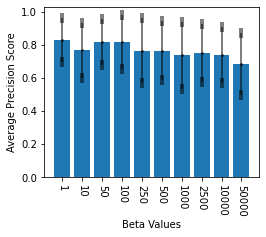

In [15]:

width = 10
height = 8
plt.figure(figsize=(width, height))
plt.bar(df_prior['beta_value'], df_prior['average_precision_mean'])
plt.xlabel('Beta Values')
plt.ylabel('Average Precision Score')
plt.errorbar(df_prior['beta_value'], df_prior['average_precision_mean'], df_prior['average_precision_sd'], fmt='.', color='Black', elinewidth=2,
             capthick=10, errorevery=1, alpha=0.5, ms=4, capsize=2)
plt.xticks(rotation=270)
plt.gcf().set_size_inches(3.8, 3.4)
plt.tight_layout()
plt.savefig(main_dir + pdf_dir + '/' + 'beta_priorVAE_regression_accuracy_plot.pdf')


Run the logisitic regression on the simple models:

In [16]:
all_accu = []
all_accu_sd = []
ave_pre = []
ave_pre_sd = []


In [17]:
for model in simple_list:
    res = np.load(model)
    X = res[idxs_loc, :]
    y_tem = organ_list
    single_accu = []
    single_accu_sd = []
    single_ave_pre = []
    single_ave_pre_sd = []
    for k in interested_organs:
        y = copy.deepcopy(y_tem)
        y = [1 if x == k else 0 for x in y_tem]
        logreg = LogisticRegression(solver='lbfgs', max_iter=8000)

        scores = cross_validate(logreg, X, y, cv=5, scoring=(
            'accuracy', 'f1', 'roc_auc', 'average_precision'), return_train_score=True)
        # DO something to iterate over 8 different organs
        single_accu.append(scores['test_accuracy'].mean())
        single_accu_sd.append(scores['test_accuracy'].std())
        single_ave_pre.append(scores['test_average_precision'].mean())
        single_ave_pre_sd.append(scores['test_average_precision'].std())

    all_accu.append(mean(single_accu))
    all_accu_sd.append(mean(single_accu_sd))
    ave_pre.append(mean(single_ave_pre))
    ave_pre_sd.append(mean(single_ave_pre_sd))


In [18]:
df_simple = pd.DataFrame({'beta_value': final_betas, 'accuracy_mean': all_accu, 'accuracy_sd': all_accu_sd,
                         'average_precision_mean': ave_pre, 'average_precision_sd': ave_pre_sd})


In [19]:
df_simple = df_simple.sort_values(['beta_value'])


In [20]:
df_simple['beta_value'] = df_simple['beta_value'].astype('str')


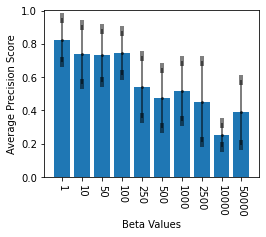

In [21]:
width = 10
height = 8
plt.figure(figsize=(width, height))
plt.bar(df_simple['beta_value'], df_simple['average_precision_mean'])
plt.xlabel('Beta Values')
plt.ylabel('Average Precision Score')
plt.errorbar(df_simple['beta_value'], df_simple['average_precision_mean'], df_simple['average_precision_sd'], fmt='.', color='Black', elinewidth=2,
             capthick=10, errorevery=1, alpha=0.5, ms=4, capsize=2)
plt.xticks(rotation=270)
plt.gcf().set_size_inches(3.8, 3.4)
plt.tight_layout()
plt.savefig(main_dir + pdf_dir + '/' +
            'beta_simpleVAE_regression_accuracy_plot.pdf')
